In [2]:
pwd

'/workspace/hbp_centermask_src'

In [ ]:
pip install -e detectron2

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Obtaining file:///workspace/hbp_centermask_src/detectron2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 50 kB 1.1 MB/s eta 0:00:011
     |████████████████████████████████| 79 kB 9.5 MB/s eta 0:00:011
     |████████████████████████████████| 154 kB 6.9 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 8.9 MB/s eta 0:00:01
     |████████████████████████████████| 117 kB 15.4 MB/s eta 0:00:01


  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61430 sha256=6034157f9507f4d874f6e0ef22370310bd6d240b46d4595153a65f6fcd63ff64
  Stored in directory: /tmp/pip-ephem-wheel-cache-ryeog090/wheels/b8/79/07/c0e9367f5b5ea325e246bd73651e8af175fabbef943043b1cc
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144573 sha256=610814122a39057957f623099d5996122bd4373e2d3da1fc1a9fea34dce40b2a
  Stored in directory: /tmp/pip-ephem-wheel-cache-ryeog090/wheels/b1/a3/c2/6df046c09459b73cc9bb6c4401b0be6c47048baf9a1617c485
  Created wheel for pycocotools: filename=pycocotools-2.0.6-cp38-cp38-linux_x86_64.whl size=422894 sha256=332080f3bd989a24dc64a1553279cd9e4fa238faf8bc2bdecfda8c0ce4f18107
  Stored in directory: /tmp/pip-ephem-wheel-cache-ryeog090/wheels/3e/08/ac/58126fe59992032701437336493f6132e1b72381a62d00b595
Successfully built fvcore antlr4-python3-runtime pycocotools
  Attempting uninstall: pycocotools
    Foun

In [3]:
!pip install -r ../requirements.txt

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


# Start

In [4]:
import sys
sys.path.append('../detectron2')

In [5]:
import centermask

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5#scrollTo=tjbUIhSxUdm_

from functions import to_coco, get_coloring
from datafunctions import DSBdata, imread, unsharp_mask
from tqdm import tqdm

def get_nuclei_dicts(offset=None,limit=None):
    datasource = DSBdata()
    records = []
    start=0
    end=len(datasource)
    if offset is not None:
        start = offset
    if limit is not None:
        end = min(start+limit+1,end)
        
    for ii in tqdm(range(start,end)):
        img,lbl=datasource.load_image(ii)
        lbl_cl, msk_2c, islands, gr, coloring = get_coloring(lbl)
        coco = to_coco(lbl,coloring)
        coco['file_name']=datasource.imgname(ii)
        coco['image_id']=ii
        records.append(coco)
    return records

In [7]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

DatasetCatalog.register("dsb_train", get_nuclei_dicts)
MetadataCatalog.get("dsb_train").set(thing_classes=["isl"]+["cl%d"%x for x in range(1,8)])


namespace(name='dsb_train',
          thing_classes=['isl',
                         'cl1',
                         'cl2',
                         'cl3',
                         'cl4',
                         'cl5',
                         'cl6',
                         'cl7'])

In [8]:
dsb_metadata = MetadataCatalog.get("dsb_train")

# visualize 

100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


0


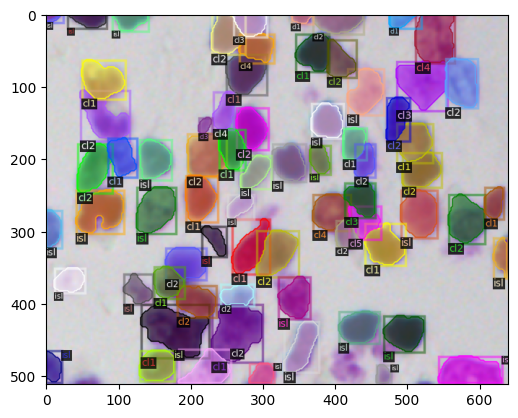

In [9]:
import random
from matplotlib import pyplot as plt
# from detectron2.utils.visualizer import ColorMode

tmp = get_nuclei_dicts(0,1)
for d in (tmp[0],):
    print(d['image_id'])
    img = imread(d['file_name'])[...,:3]
    visualizer = Visualizer(img, metadata=dsb_metadata, scale=2)
    out = visualizer.draw_dataset_dict(d)
    plt.figure()
    plt.imshow(out.get_image())

In [11]:
# tmp[0]

In [12]:
imgid=0

datasource = DSBdata()
img,lbl = datasource.load_image(imgid)

lbl_cl, msk_2c, islands, gr, coloring = get_coloring(lbl)



In [13]:
img.shape,img.dtype

((256, 320, 3), dtype('uint8'))

Text(0.5, 1.0, 'coloring')

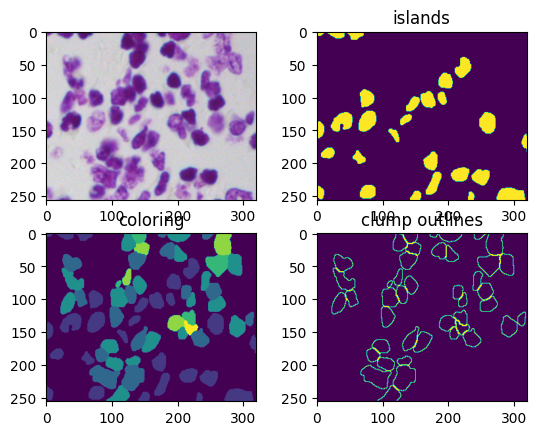

In [14]:
plt.subplot(2,2,1)
plt.imshow(img)

plt.subplot(2,2,2)
plt.imshow(msk_2c[...,0])
plt.title('islands')

plt.subplot(2,2,4)
plt.imshow(msk_2c[...,1])
plt.title('clump outlines')

plt.subplot(2,2,3)
plt.imshow(lbl_cl)
plt.title('coloring')

In [15]:
img.max(axis=1).max(axis=0)

array([243, 226, 247], dtype=uint8)

In [16]:
img[...,0].max(),img[...,1].max(), img[...,2].max()

(243, 226, 247)

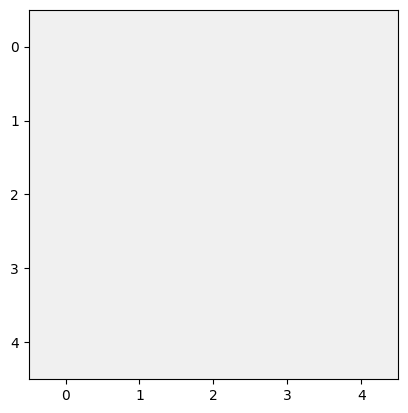

In [17]:
import numpy as np
abc=np.ones((5,5,3),np.uint8)
abc[...,0]=240
abc[...,1]=240
abc[...,2]=240
plt.imshow(abc)

In [18]:
# np.flip(img.max(axis=1).max(axis=0),axis=0)

# detectron training

In [19]:
# https://detectron2.readthedocs.io/en/latest/tutorials/data_loading.html#write-a-custom-dataloader

import detectron2.data.transforms as T
from detectron2.data import (
    detection_utils as utils, 
    build_detection_train_loader
)
import copy
import torch

def mapper(dataset_dict):
    d = copy.deepcopy(dataset_dict)  
    image = imread(d['file_name'])[...,:3]
    image = unsharp_mask(image,preserve_range=True, channel_axis=2)
    # image = utils.read_image(dataset_dict["file_name"], format="BGR")
    # See "Data Augmentation" tutorial for details usage
    auginput = T.AugInput(image)
    transform1 = T.RandomFlip(horizontal=True,vertical=False)(auginput)
    transform2 = T.RandomFlip(horizontal=False,vertical=True)(auginput)
    transform3 = T.RandomRotation([-15,15],expand=False,center=[[-0.2,-0.2],[0.2,0.2]],)(auginput)
    image = torch.from_numpy(auginput.image.transpose(2, 0, 1)).float()
    annos = [
        utils.transform_instance_annotations(annotation, [transform1, transform2, transform3], image.shape[1:])
        for annotation in dataset_dict.pop("annotations")
    ]
    return {
       # create the format that the model expects
       "image": image,
        "width":image.shape[-1],
        "height":image.shape[-2],
       "instances": utils.annotations_to_instances(annos, image.shape[1:])
    }


In [20]:
ls configs/centermask/

Base-CenterMask-Lite-VoVNet.yaml*
Base-CenterMask-ResNet.yaml*
Base-CenterMask-VoVNet.yaml*
Base-Panoptic-ResNet-FPN.yaml*
Base-Panoptic-VoVNet-FPN.yaml*
centermask_R_101_FPN_ms_3x.yaml*
centermask_R_50_FPN_ms_3x.yaml*
centermask_V_39_eSE_FPN_ms_3x.yaml*
centermask_V_39_eSE_dcn_FPN_ms_3x.yaml*
centermask_V_57_eSE_FPN_ms_3x.yaml*
centermask_V_57_eSE_dcn_FPN_ms_3x.yaml*
centermask_V_99_eSE_FPN_ms_3x.yaml*
centermask_V_99_eSE_dcn_FPN_ms_3x.yaml*
centermask_X_101_FPN_ms_3x.yaml*
centermask_lite_Mv2_FPN_ms_4x.yaml*
centermask_lite_V_19_eSE_FPN_ms_4x.yaml*
centermask_lite_V_19_slim_dw_eSE_FPN_ms_4x.yaml*
centermask_lite_V_19_slim_eSE_FPN_ms_4x.yaml*
centermask_lite_V_39_eSE_FPN_ms_4x.yaml*
panoptic_centermask_R_101_FPN_ms_3x.yaml*
panoptic_centermask_R_50_FPN_ms_3x.yaml*
panoptic_centermask_V_39_eSE_FPN_ms_3x.yaml*
panoptic_centermask_V_57_eSE_FPN_ms_3x.yaml*
panoptic_centermask_V_99_eSE_FPN_ms_3x.yaml*
panoptic_centermask_X_101_FPN_ms_3x.yaml*


In [21]:
# !wget https://www.dropbox.com/s/q98pypf96rhtd8y/vovnet39_ese_detectron2.pth?dl=1

In [22]:
# from detectron2.config import get_cfg
from centermask.config import get_cfg

cfg = get_cfg()
# cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
# cfg.merge_from_file('configs/centermask/centermask_V_39_eSE_FPN_ms_3x.yaml')
cfg.merge_from_file('configs/centermask/centermask_R_50_FPN_ms_3x.yaml')
cfg.DATASETS.TRAIN = ("dsb_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo

cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 8  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.



Config 'configs/centermask/centermask_R_50_FPN_ms_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


In [23]:
# dataloader = build_detection_train_loader(cfg, mapper=mapper)

In [24]:
from detectron2.engine import DefaultTrainer

class MyTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls,cfg):
        return build_detection_train_loader(cfg,mapper=mapper)

In [25]:
import os

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = DefaultTrainer(cfg) 
trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)


[03/13 18:30:33 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (

 47%|████▋     | 17/36 [00:13<00:17,  1.10it/s]

skipping small polygon


 50%|█████     | 18/36 [00:14<00:15,  1.17it/s]

skipping small polygon


100%|██████████| 36/36 [00:29<00:00,  1.23it/s]

[03/13 18:31:02 d2.data.build]: Removed 0 images with no usable annotations. 36 images left.
[03/13 18:31:02 d2.data.build]: Distribution of instances among all 8 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|    isl     | 1084         |    cl1     | 299          |    cl2     | 353          |
|    cl3     | 23           |    cl4     | 16           |    cl5     | 3            |
|    cl6     | 0            |    cl7     | 0            |            |              |
|   total    | 1778         |            |              |            |              |
[03/13 18:31:02 d2.data.build]: Using training sampler TrainingSampler
[03/13 18:31:02 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[03/13 18:31:02 d2.data.common]: Serializing 36 elements to byte tensors and concatenating them all ...
[03/13 18:31:02 

[03/13 18:31:02 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from detectron2://ImageNetPretrained/MSRA/R-50.pkl ...
[03/13 18:31:02 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[03/13 18:31:02 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up:
| Names in Model    | Names in Checkpoint      | Shapes                                          |
|:------------------|:-------------------------|:------------------------------------------------|
| res2.0.conv1.*    | res2_0_branch2a_{bn_*,w} | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| res2.0.conv2.*    | res2_0_branch2b_{bn_*,w} | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.0.conv3.*    | res2_0_branch2c_{bn_*,w} | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.0.shortcut.* | res2_0_branch1_{bn_*,w}  | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.1.conv1.*    | res2_1_branch2a_{bn_*,w} | (64,) (64,) (64,) (64,) (64

Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
backbone.top_block.p6.{bias, weight}
backbone.top_block.p7.{bias, weight}
proposal_generator.fcos_head.bbox_pred.{bias, weight}
proposal_generator.fcos_head.bbox_tower.0.{bias, weight}
proposal_generator.fcos_head.bbox_tower.1.{bias, weight}
proposal_generator.fcos_head.bbox_tower.10.{bias, weight}
proposal_generator.fcos_head.bbox_tower.3.{bias, weight}
proposal_generator.fcos_head.bbox_tower.4.{bias, weight}
proposal_generator.fcos_head.bbox_tower.6.{bias, weight}
proposal_generator.fcos_head.bbox_tower.7.{bias, weight}
proposal_generator.fcos_head.bbox_tower.9.{bias, weight}
proposal_generator.fcos_head.cls_logits.{bias, weight}
proposal_generator.fcos_head.cls_tower.0.{bias, weight}
proposal_generator.

In [26]:
# dir(trainer)

In [27]:
elt=next(iter(trainer.data_loader))

In [28]:
elt=next(iter(trainer.data_loader.dataset))

In [29]:
elt['image'].shape

torch.Size([3, 256, 320])

In [30]:
im=elt['image'].permute(1,2,0)

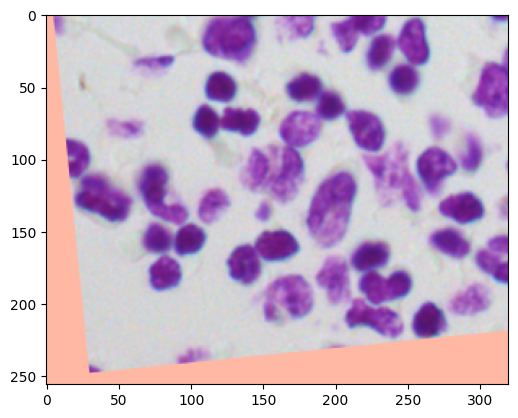

In [31]:
import numpy as np
plt.imshow(im.numpy().astype(np.uint8))

In [31]:
elt.keys()

dict_keys(['image', 'width', 'height', 'instances'])

# training

In [32]:
# trainer.train()